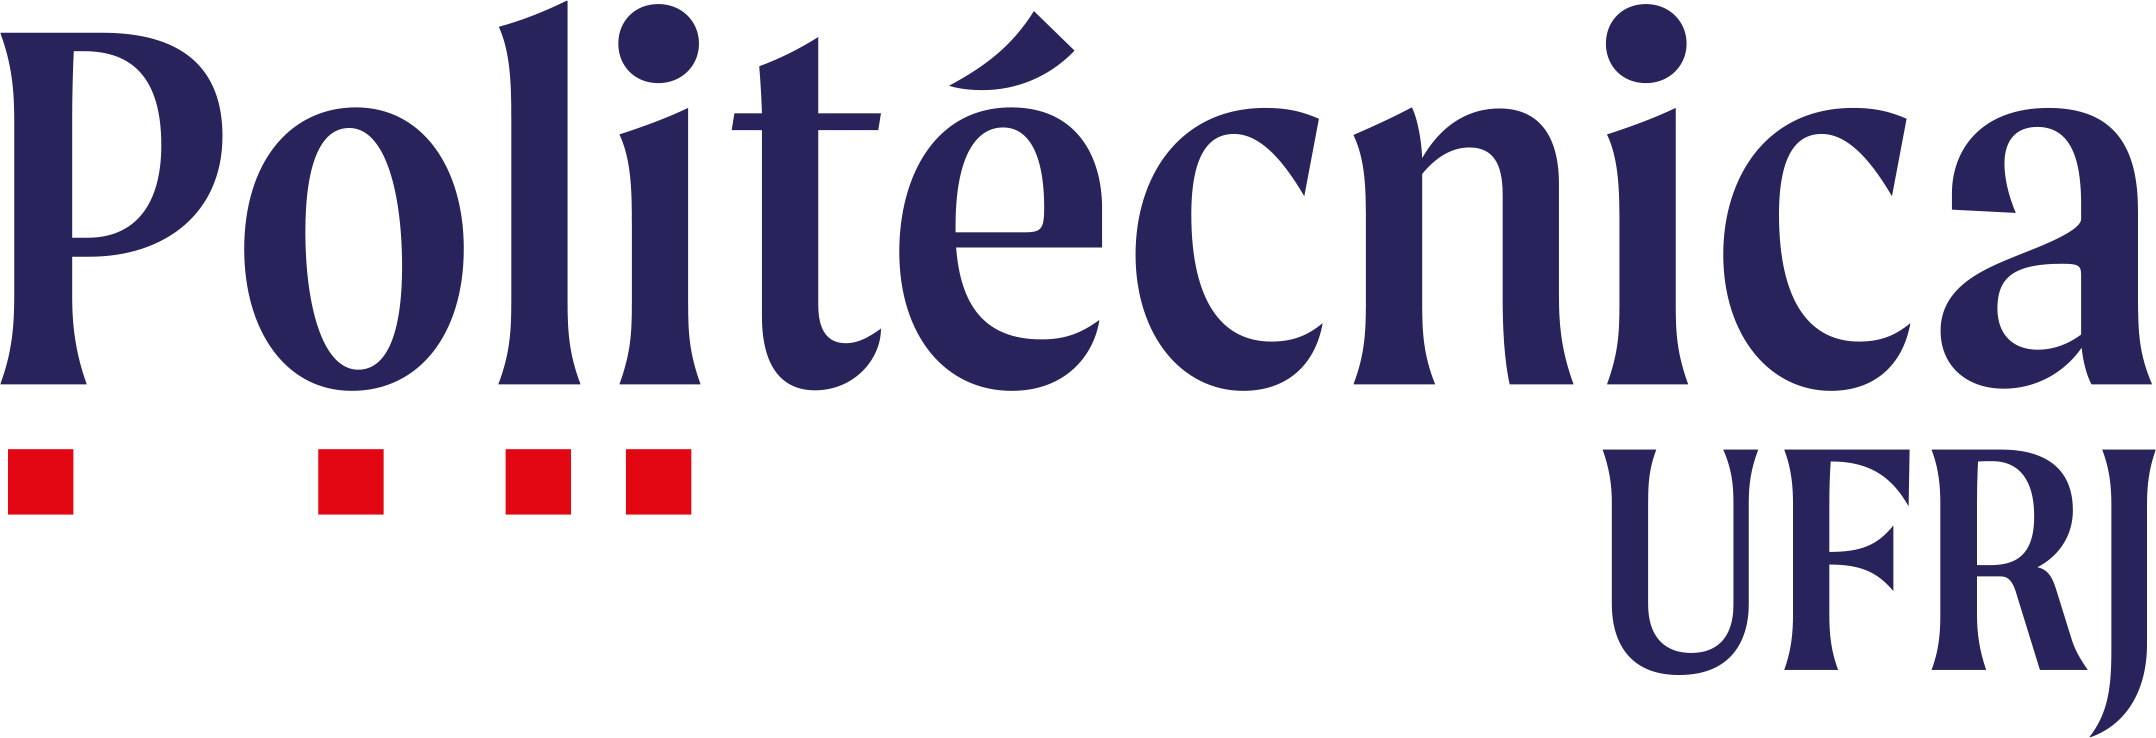

[texto do link](https://)  Sistema de inserção de contratos de pagmentos de forma **manual** na planilha de controle





    última atualização: 22/jul./25


# Bibliotecas e Conexão Drive
Instala bibliotecas e prepara ambiente

(rodar apenas uma vez para iniciar o sistema)

In [2]:
import gspread
from google.colab import auth
from googleapiclient.discovery import build
from google.auth.transport.requests import Request
from google.auth import default
from IPython.display import clear_output
import time
from datetime import datetime
from dateutil.relativedelta import relativedelta
import gspread.utils


In [3]:
import os

def clear():
    os.system('cls' if os.name == 'nt' else 'clear')


# Inserção


In [ ]:
def converteValor(valor_str): #Converte uma string de valor monetário para float
    try:
        # remove pontos (separador de milhar) e substitui vírgula por ponto (decimal)
        valor_str = valor_str.replace('.', '').replace(',', '.')
        return float(valor_str)
    except ValueError:
        print(f"Erro ao converter o valor: '{valor_str}'")
        return None


# função para calcular a posição da coluna
def index(mes, ano):
    posicao = (ano - 2021) * 12 + mes - 7
    posicao += 9  # começando na coluna I
    return posicao

# função para selecionar o sheet desejado
def selecionaSheet(gspread_client):
    # solicita ao usuário o caminho do arquivo no Google Drive
    caminho = input("Ir para planilha /Contratos de Cursos divididos por departamento/? (S/N) ").strip()
    clear()

    if caminho.upper() == "N":
      file_path = input("Insira o ID ou URL do arquivo do Google Sheets no seu Drive: ").strip()
    #else:
      #file_path = ""

    try:
        if "https://" in file_path:
            # extrai o ID da URL se for uma URL completa
            file_id = file_path.split('/d/')[1].split('/')[0]
        else:
           # se não, acessa drive pelo endereço
            file_id = file_path

        spreadsheet = gspread_client.open_by_key(file_id)
        print("Planilha carregada com sucesso!")

        # printa os nomes dos sheets disponíveis
        sheets = spreadsheet.worksheets()
        print("Sheets disponíveis:")
        for idx, sheet in enumerate(sheets, start=1):
            print(f"{idx} - {sheet.title}")

        # solicita a escolha do sheet
        choice = int(input("\nDigite o número do sheet que deseja acessar (ex.: 1 ou 2): ").strip())
        if choice < 1 or choice > len(sheets):
            print("Número inválido. Encerrando o programa.")
            return None, None

        sheet = sheets[choice - 1]
        print(f"Você escolheu o sheet: {sheet.title}")
        return sheet, spreadsheet

    except Exception as e:
        print(f"Ocorreu um erro: {e}")
        return None, None

# função para encontrar a última linha preenchida
def encontraUltimaLinha(sheet):
    values = sheet.get_all_values()
    for idx, row in enumerate(reversed(values), start=1):
        if any(cell.strip() for cell in row):  # verifica se há alguma célula não vazia
            return len(values) - idx + 2
    return 2  # se não tiver valores, começa na linha 2

# função para inserir turma e alunos
def insereTurma(sheet, spreadsheet):
    target_row = encontraUltimaLinha(sheet)

    curso = input("Digite o curso: ").strip()
    codigo_turma = input("Digite o código da turma: ").strip()

    header = ["", curso, "Curso/Turma", "Projeto Fundação", "Valor Total", "N° de Parcelas", "Valor da Parcela", "Entrada"]
    sheet.update(values=[header], range_name=f"A{target_row}:H{target_row}")

    linha_inicial = target_row + 1
    contador_alunos = 1

    while True:
        print("\n")
        nome_aluno = input(f"Digite o nome do {contador_alunos}° aluno (ou SAIR para finalizar): ").strip()
        if nome_aluno.upper() == "SAIR":
            print("Finalizando inserção de alunos.")
            break

        try:
            valor_total = input(f"Digite o valor total para {nome_aluno}: ").strip()
            valor_total = converteValor(valor_total)
        except ValueError:
            print("Valor inválido. Tente novamente.")
            continue

        try:
            entrada = input(f"Digite o valor da entrada para {nome_aluno}(caso nao tenha, digite 0): ").strip()
            entrada = converteValor(entrada)
            valor_total -= entrada
            if entrada == 0:
                entrada = "-"
        except ValueError:
            print("Valor inválido. Tente novamente.")
            continue

        try:
            num_parcelas = int(input(f"Digite o número de parcelas para {nome_aluno}: ").strip())
            if num_parcelas <= 0:
                raise ValueError
        except ValueError:
            print("Número de parcelas inválido. Tente novamente.")
            continue

        try:
            if contador_alunos > 1:
                print(f"Data atual usada para a primeira parcela: {data_inicial.strftime('%m/%y')}")
                mesmaData = input("Usar a mesma data? (S/N): ").strip()
            else:
                mesmaData = "N"

            if mesmaData.upper() == "N" or contador_alunos == 1:
                mes_ano = input(f"Digite o mês e ano da primeira parcela no formato MM/AA para {nome_aluno}: ").strip()
                data_inicial = datetime.strptime(mes_ano, "%m/%y")

        except ValueError:
            print("Formato de data inválido. Tente novamente.")
            continue


        except ValueError:
            print("Formato de data inválido. Tente novamente.")
            continue

        valor_parcela = valor_total / num_parcelas

        clear()
        print("\nCONFIRMAÇÃO")
        print("Nome: ", nome_aluno)
        print("Valor Total: ", valor_total)
        print("Valor Entrada: ", entrada)
        print("Quantidade de Parcelas: ", num_parcelas)
        print("Valor Parcelas: ", valor_parcela)
        print("\n")

        primeira_parcela_col = index(data_inicial.month, data_inicial.year)

        aluno_data = [contador_alunos, nome_aluno, curso, codigo_turma, valor_total, num_parcelas, valor_parcela, entrada]
        sheet.update(values=[aluno_data], range_name=f"A{target_row + contador_alunos}:H{target_row + contador_alunos}")

        for i in range(num_parcelas):
            col = primeira_parcela_col + i
            col_ref = gspread.utils.rowcol_to_a1(target_row + contador_alunos, col)

            if i == 0:
                parcela_valor = valor_parcela + (entrada if isinstance(entrada, float) else 0)
            else:
                parcela_valor = valor_parcela

            sheet.update(values=[[parcela_valor]], range_name=col_ref)

        contador_alunos += 1

    linha_final = target_row + contador_alunos - 1

    # copia para o primeiro sheet apenas (se não for ele)
    sheet_destino = spreadsheet.worksheets()[0]
    if sheet.id != sheet_destino.id:
        intervalo_copiado = sheet.get(f"A{target_row}:ZZ{linha_final}")
        destino_row = encontraUltimaLinha(sheet_destino)
        sheet_destino.update(f"A{destino_row}", intervalo_copiado)
        print(f"Linhas copiadas para o primeiro sheet: {sheet_destino.title}")
    else:
        print("Você está no primeiro sheet, portanto não será feita cópia.")

    resposta = input("Gostaria de adicionar uma nova turma nesse departamento? (S - SIM / N - NÃO): ").strip().upper()
    if resposta == "S":
        insereTurma(sheet, spreadsheet)
    elif resposta == "N":
        return False
    return True



def main():
    # autenticação
    auth.authenticate_user()
    creds, _ = default()
    creds.refresh(Request())
    gspread_client = gspread.authorize(creds)

    while True:
        # chama a função de seleção de sheet
        sheet, spreadsheet = selecionaSheet(gspread_client)
        if not sheet:
            break  # encerra o programa se não conseguir selecionar o sheet

        # insere a turma e os alunos
        continuar = insereTurma(sheet, spreadsheet)
        if not continuar:
            break  # sai do loop se o usuário não quiser adicionar mais turmas

if __name__ == "__main__":
    main()


